In [2]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import SALib as salib
from SALib.sample import sobol as salib_sample_sobol
from SALib.analyze import delta, dgsm, fast, ff, hdmr, morris, pawn, rbd_fast, sobol

import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer
import embera

from src.particle_funcs import distance_matrix as distance_matrix
import src.leap_funcs.qubo.q_matrix as q_matrix
from src.leap_funcs import embedding_quality
from src.leap_funcs.qubo import filter_samples

from src import h5py_funcs
from src.h5py_funcs import discoveries, init_custom_getstates, io, parameterstudy_using_info_file

Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.


In [3]:
#emb_suffix = ['_mm', '_em', '_em_wo_migration', '_em_layout', '_em_wo_migration_layout']
emb_suffix = ['_em_wo_migration_layout']
#file_suffix= ['01', '02', '03', '04', '05', '06', '07', '08', '09']
file_suffix= ['09']

#list_num_particles = [5, 10]
list_num_particles = [5]
correct_sol = {'5_particles': np.array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
                                        1.]),
               '10_particles': np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
                                        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
                                        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
                                        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
                                        0., 0., 0., 1.])
                }
collection_samples_params = {'{}_parts'.format(n): {'params':{}, 'samples':{}} for n in list_num_particles}
for n_p, num_particles_key in enumerate(collection_samples_params.keys()):
    for file_suffix_id in range(len(file_suffix)):
        collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]] = {}
        collection_samples_params[num_particles_key]['params'][file_suffix[file_suffix_id]] = {}
        
        #with h5py.File(data_file_name_path_emb, 'r') as f:
        #    collection_samples_params[num_particles_key]['params'][file_suffix[file_suffix_id]]['embera'] = {'tries': f['embedding_meta/embera_kwargs_diffusion_candidates/tries'][()]}
        #    collection_samples_params[num_particles_key]['params'][file_suffix[file_suffix_id]]['minorminer'] = {'chainlength_patience': f['embedding_meta/minorminer_kwargs/chainlength_patience'][()],
        #                                                                                      'max_no_improvement': f['embedding_meta/minorminer_kwargs/max_no_improvement'][()],
        #                                                                                      'tries': f['embedding_meta/minorminer_kwargs/tries'][()]}
        for emb_suffix_id in range(len(emb_suffix)):
            collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]] = {}
            collection_samples_params[num_particles_key]['params'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]] = {}

            print('file_suffix_id:', file_suffix_id, 'emb_suffix_id:', emb_suffix_id)
            print('file_suffix:', file_suffix[file_suffix_id], 'emb_suffix:', emb_suffix[emb_suffix_id])

            folder_path = 'test_params_annealer'
            folder_path = os.path.relpath(folder_path)
            folder_path = os.path.join(folder_path, '_orig')
            data_file_name = 'parameterstudy_data_{}_{}_{}.h5'.format(list_num_particles[n_p], emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
            data_file_name_path = os.path.join(folder_path, data_file_name)
            info_file_name = 'parameterstudy_info_{}_{}_{}.h5'.format(list_num_particles[n_p], emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
            info_file_name_path = os.path.join(folder_path, info_file_name)

            
            
            with h5py.File(info_file_name_path, 'r') as f:
                print('f.keys():', f.keys())
                #params_dict['study'] = 
                params_array = f['parametersets/study'][()]
                
                _tmp = {key: value[()] for key, value in f['parametersets/time_history'].items()}
                _tmp_attrs = {key: value[()] for key, value in f['parametersets/time_history'].attrs.items()}
                time_history = {}
                time_history['data'] = _tmp.copy()
                time_history['attrs'] = _tmp_attrs.copy()

            print('type(params_array):', type(params_array))
            print('params_array.dtype:', params_array.dtype)
            print('params_array.shape:', params_array.shape)
            print('params_array.ndim:', params_array.ndim)
            print('params_array.size:', params_array.size)

            print('type(time_history):', type(time_history))
            print('type(time_history[attrs][order]):', type(time_history['attrs']['order']))
            print('type(time_history[attrs][order].dtype):', type(time_history['attrs']['order'].dtype))
            print('type(time_history[attrs][order][0]):', type(time_history['attrs']['order'][0]))
            #print('type(time_history[attrs][order][0].dtype):', type(time_history['attrs']['order'][0].dtype))
            print('time_history[attrs][order][0]:', time_history['attrs']['order'][0])
            print('type(time_history[data][zz_0010641379]):', type(time_history['data']['zz_0010641379']))
            print('time_history[data][zz_0010641379].dtype:', time_history['data']['zz_0010641379'].dtype)
            print('time_history[data][zz_0010641379].shape:', time_history['data']['zz_0010641379'].shape)
            print('time_history[data][zz_0010641379].ndim:', time_history['data']['zz_0010641379'].ndim)
            print('time_history[data][zz_0010641379].size:', time_history['data']['zz_0010641379'].size)
            
            #a = {key: [val_i.decode('utf-8')[0:19] for val_i in value] for key, value in time_history['data'].items()}
            #print(a)
            #b = {key: [np.array(val_i[0:20], dtype=np.datetime64)-np.timedelta64(1, 'h') for val_i in value] for key, value in a.items()}
            #print(b)
            time_history['data'] = {key: np.array([v.decode('utf-8') for v in value]) for key, value in time_history['data'].items()}
            print(time_history)
            print(time_history['data']['zz_0010641379'][0])

            with h5py.File(data_file_name_path, 'r') as f:
                samplesets_dict = h5py_funcs.io.read_groups_recursively_from_hdf5_object(f['sampleset'])
            
                
            h5py_funcs.discoveries.discover_obj_data_for_hdf5(samplesets_dict)



            counter_valid_samplesets = 0
            ids_valid_samplesets = set()
            counter_valid_and_optimal_samplesets = 0
            ids_valid_and_optimal_samplesets = set()
            collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['valid_samples'] = []
            collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['optimal_samples'] = []

            for _id in samplesets_dict.keys():
                counter_valid_samples = 0
                ids_valid_samples= []
                counter_valid_and_optimal_samples = 0
                ids_valid_and_optimal_samples = []

                for k, sol in enumerate(samplesets_dict[_id]['sample_data']['data']):
                        parts = 0
                        poss = 0
                        valid_parts = True
                        valid_poss = True
                        for i in range(list_num_particles[n_p]):
                            parts = 0
                            for j in range(list_num_particles[n_p]):
                                parts += sol[i*list_num_particles[n_p] +j]
                            #print('parts ', parts)
                            if parts != 1:
                                valid_parts = False

                        for j in range(list_num_particles[n_p]):
                            poss = 0
                            for i in range(list_num_particles[n_p]):
                                poss += sol[i*list_num_particles[n_p] +j]
                            #print('poss ', poss)
                            if poss != 1:
                                valid_poss = False

                        if valid_parts and valid_poss:
                            ids_valid_samples.append(k)
                            counter_valid_samples += 1
                            ids_valid_samplesets.add(_id)
                            counter_valid_samplesets = len(ids_valid_samplesets)

                for i, sol in enumerate(samplesets_dict[_id]['sample_data']['data']):
                    if i in ids_valid_samples:
                        if np.array_equal(correct_sol[f'{list_num_particles[n_p]}_particles'].astype(int), sol):
                            ids_valid_and_optimal_samples.append(i)
                            counter_valid_and_optimal_samples += 1
                            ids_valid_and_optimal_samplesets.add(_id)
                            counter_valid_and_optimal_samplesets = len(ids_valid_and_optimal_samplesets)

                if counter_valid_samples == len(ids_valid_samples):
                    collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['valid_samples'].append(ids_valid_samples)
                else:
                    raise ValueError('  WARNING: counter_valid_samples != len(ids_valid_samples)')
                if counter_valid_and_optimal_samples == len(ids_valid_and_optimal_samples):
                    collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['optimal_samples'].append(ids_valid_and_optimal_samples)
                else:
                    raise ValueError('  WARNING: counter_valid_and_optimal_samples != len(ids_valid_and_optimal_samples)')

            if counter_valid_samplesets == len(ids_valid_samplesets):
                collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['valid_sets'] = ids_valid_samplesets
            else:
                raise ValueError('  WARNING: counter_valid_samplesets != len(ids_valid_samplesets)')
            if counter_valid_and_optimal_samplesets == len(ids_valid_and_optimal_samplesets):
                collection_samples_params[num_particles_key]['samples'][file_suffix[file_suffix_id]][emb_suffix[emb_suffix_id]]['optimal_sets'] = ids_valid_and_optimal_samplesets
            else:
                raise ValueError('  WARNING: counter_valid_and_optimal_samplesets != len(ids_valid_and_optimal_samplesets)')

            print('  num. valid   samplesets:', counter_valid_samplesets)
            print('  num. correct samplesets:', counter_valid_and_optimal_samplesets)
            print('  num. valid   samples   :', counter_valid_samples)
            print('  num. correct samples   :', counter_valid_and_optimal_samples)




file_suffix_id: 0 emb_suffix_id: 0
file_suffix: 09 emb_suffix: _em_wo_migration_layout
f.keys(): <KeysViewHDF5 ['parametersets']>
type(params_array): <class 'numpy.ndarray'>
params_array.dtype: [('sets', [('annealing_time', '<f8'), ('programming_thermalization', '<f8'), ('readout_thermalization', '<f8')], (1,)), ('identifiers', 'S13')]
params_array.shape: (2048,)
params_array.ndim: 1
params_array.size: 2048
type(time_history): <class 'dict'>
type(time_history[attrs][order]): <class 'numpy.ndarray'>
type(time_history[attrs][order].dtype): <class 'numpy.dtypes.ObjectDType'>
type(time_history[attrs][order][0]): <class 'str'>
time_history[attrs][order][0]: creation
type(time_history[data][zz_0010641379]): <class 'numpy.ndarray'>
time_history[data][zz_0010641379].dtype: |S24
time_history[data][zz_0010641379].shape: (3,)
time_history[data][zz_0010641379].ndim: 1
time_history[data][zz_0010641379].size: 3
{'data': {'zz_6843941827': array(['2024-01-01T00:38:21+0100', '2024-01-01T00:38:27+0100',

In [4]:
print(collection_samples_params['5_parts']['samples']['09']['_em_wo_migration_layout']['valid_samples'])

[[0, 4, 5, 6, 7, 10, 11, 12, 14, 17, 18, 19, 20, 23, 25, 26, 28, 29, 30, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 46, 47, 49, 51, 52, 53, 55, 57, 58, 59, 61, 63, 64, 65, 66, 68, 69, 70, 73, 74, 77, 78, 79, 80, 81, 82, 84, 85, 87, 88, 89, 91, 96, 98, 99, 100, 102, 103, 104, 106, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 145, 146, 148, 149, 150, 155, 157, 159, 164, 165, 168, 171, 172, 173, 174, 176, 179, 181, 182, 183, 184, 185, 187, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 204, 207, 208, 209, 211, 212, 213, 214, 215, 217, 218, 219, 220, 222, 224, 225, 226, 228, 229, 230, 232, 234, 235, 236, 237, 238, 240, 241, 242, 244, 246, 248, 250, 252, 253, 254, 255, 256, 257, 261, 262, 263, 265, 266, 267, 268, 269, 271, 272, 273, 275, 277, 278, 279, 280, 281, 282, 283, 284, 286, 288, 289, 290, 291, 292, 293, 294, 295, 298, 299, 300, 301, 302, 304, 305, 306, 307, 309, 31

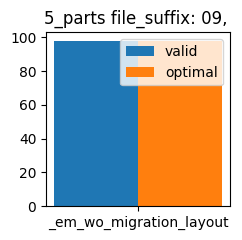

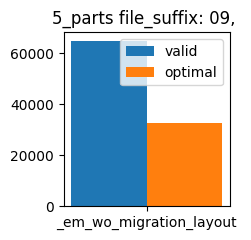

In [5]:
fig_size = (2.5*len(emb_suffix), 2.5*len(list_num_particles))
fig_sets, axs_sets = plt.subplots(len(file_suffix), len(list_num_particles), figsize=fig_size)
fig_samples, axs_samples = plt.subplots(len(file_suffix), len(list_num_particles), figsize=fig_size)

for n_p, num_particles_key in enumerate(collection_samples_params.keys()):
    for i in range(len(file_suffix)):
        def axs_obj(base_obj, x1=len(file_suffix), x2=len(list_num_particles)): 
            if x1 > 1 and x2 > 1: return base_obj[i, n_p]
            elif x1 > 1 and x2 == 1: return base_obj[i]
            elif x1 == 1 and x2 > 1: return base_obj[n_p]
            elif x1 == 1 and x2 == 1: return base_obj
        
        if len(file_suffix) > 1: ids_plots = i, n_p 
        else: ids_plots = n_p
        x_poss_0 = np.arange(len(emb_suffix))
        x_labels_0 = emb_suffix
        width_0 = 0.35
        data_1_0 = np.array([len(collection_samples_params[num_particles_key]['samples'][file_suffix[i]][emb_suffix[j]]['valid_sets']) for j in range(len(emb_suffix))])
        data_2_0 = np.array([len(collection_samples_params[num_particles_key]['samples'][file_suffix[i]][emb_suffix[j]]['optimal_sets']) for j in range(len(emb_suffix))])
        title_0 = str(num_particles_key) + ' file_suffix: {}, '.format(file_suffix[i])# \
#                + '\n' + 'embera:' + collection_samples_params[num_particles_key]['params'][file_suffix[i]]['embera'].__str__() \
#                + '\n' + 'minorminer:' + collection_samples_params[num_particles_key]['params'][file_suffix[i]]['minorminer'].__str__()
        axs_obj(axs_sets).bar(x_poss_0 - width_0/2, data_1_0, width_0, label='valid')
        axs_obj(axs_sets).bar(x_poss_0 + width_0/2, data_2_0, width_0, label='optimal')
        axs_obj(axs_sets).set_xticks(x_poss_0)
        axs_obj(axs_sets).set_xticklabels(x_labels_0)
        axs_obj(axs_sets).set_title(title_0)
        axs_obj(axs_sets).legend()
        x_poss_1 = np.arange(len(emb_suffix))
        x_labels_1 = emb_suffix
        width_1 = 0.35
        data_1_1 = []
        data_2_1 = []
        for j in range(len(emb_suffix)):
            _tmp = collection_samples_params[num_particles_key]['samples'][file_suffix[i]][emb_suffix[j]]
            data_1_1.append(0)
            data_2_1.append(0)
            for k in range(len(_tmp['valid_samples'])):
                data_1_1[j] += len(_tmp['valid_samples'][k])
                data_2_1[j] += len(_tmp['optimal_samples'][k])
        data_1_1 = np.array(data_1_1)
        data_2_1 = np.array(data_2_1)
        title_1 = title_0
        axs_obj(axs_samples).bar(x_poss_1 - width_0/2, data_1_1, width_0, label='valid')
        axs_obj(axs_samples).bar(x_poss_1 + width_0/2, data_2_1, width_0, label='optimal')
        axs_obj(axs_samples).set_xticks(x_poss_1)
        axs_obj(axs_samples).set_xticklabels(x_labels_1)
        axs_obj(axs_samples).set_title(title_1)
        axs_obj(axs_samples).legend()

fig_sets.tight_layout()
fig_samples.tight_layout()

In [6]:
try:
    with h5py.File('test_params_annealer/merged/parameterstudy_data_5__em_wo_migration_layout_09.h5', 'r+') as f:
        a = [key for key in f['sampleset_00']['sampleset'].keys()]
        b = [key for key in f['sampleset_01']['sampleset'].keys()]
        c = [key for key in f['sampleset_02']['sampleset'].keys()]
        
        
        print(len(a), a)
        print(len(b), b)
        print(len(c), c)
        
        for _id in f['sampleset_00']['sampleset'].keys():
            if _id in f['sampleset_01']['sampleset'].keys():
                print('_id in 00 an 01 :', _id)
            if _id in f['sampleset_02']['sampleset'].keys():
                print('_id in 00 an 02 :', _id)
        


except Exception as e:
    print(e)          

"Unable to synchronously open object (object 'sampleset_00' doesn't exist)"


In [6]:
info_file_name_path = 'test_params_annealer/merged/zz_first_merge_parameterstudy_info_5__em_wo_migration_layout_09.h5'
data_file_name_path = 'test_params_annealer/merged/zz_first_merge_parameterstudy_data_5__em_wo_migration_layout_09.h5'

try:
    with h5py.File(info_file_name_path, 'r+') as info, h5py.File(data_file_name_path, 'r+') as data:
        info_a = [key for key in info['parametersets_00']['parametersets'].keys()]
        info_b = [key for key in info['parametersets_01']['parametersets'].keys()]
        info_c = [key for key in info['parametersets_02']['parametersets'].keys()]
        info_d = [key for key in info['parametersets_00']['parametersets']['time_history'].keys()]
        info_e = [key for key in info['parametersets_01']['parametersets']['time_history'].keys()]
        info_f = [key for key in info['parametersets_02']['parametersets']['time_history'].keys()]
        info_g = {key: value for key, value in info['parametersets_00']['parametersets'].attrs.items()}
        info_h = {key: value for key, value in info['parametersets_01']['parametersets'].attrs.items()}
        info_i = {key: value for key, value in info['parametersets_02']['parametersets'].attrs.items()}

        data_a = [key for key in data['sampleset_00']['sampleset'].keys()]
        data_b = [key for key in data['sampleset_01']['sampleset'].keys()]
        data_c = [key for key in data['sampleset_02']['sampleset'].keys()]
        
        print(len(info_a), info_a)
        print(len(info_b), info_b)
        print(len(info_c), info_c)
        print(len(info_d), info_d)
        print(len(info_e), info_e)
        print(len(info_f), info_f)

        print(len(data_a), data_a)
        print(len(data_b), data_b)
        print(len(data_c), data_c)

        print('\n', '\n', '\n')


        ids_in_info_00_and_info_01 = []
        ids_in_info_00_and_info_02 = []
        ids_in_info_01_and_info_02 = []
        for _id in info_d:
            if _id in info_e:
                #print('_id in info 00 and info 01 :', _id)
                ids_in_info_00_and_info_01.append(_id)
            if _id in info_f:
                #print('_id in info 00 and info 02 :', _id)
                ids_in_info_00_and_info_02.append(_id)
        for _id in info_e:
            if _id in info_f:
                #print('_id in info 01 and info 02 :', _id)
                ids_in_info_01_and_info_02.append(_id)
        print('id in info [00, 01, 02] in info [00, 01, 02]')
        print(len(ids_in_info_00_and_info_01), len(ids_in_info_00_and_info_01), len(ids_in_info_01_and_info_02))
        print(ids_in_info_00_and_info_01)
        print(ids_in_info_00_and_info_02)
        print(ids_in_info_01_and_info_02)


        print('\n', '\n', '\n')


        for key, value in info_g.items():
            if key in info_h.keys():
                print('key in info_attrs 00 and info_attrs 01 :', key, value, info_h[key])
            if key in info_i.keys():
                print('key in info_attrs 00 and info_attrs 02 :', key, value, info_i[key])
        for key, value in info_h.items():
            if key in info_i.keys():
                print('key in info_attrs 01 and info_attrs 02 :', key, value, info_i[key])


        print('\n', '\n', '\n')


        study_00 = info['parametersets_00']['parametersets']['study'][()]
        study_01 = info['parametersets_01']['parametersets']['study'][()]
        study_02 = info['parametersets_02']['parametersets']['study'][()]
        print('parametersets')
        print(study_00.dtype)
        print(study_00)
        print(study_01)
        print(study_02)
        print('study_00.sets equal to study_01.sets ?', (study_00['sets'] == study_01['sets']).all())
        print('study_00.sets equal to study_02.sets ?', (study_00['sets'] == study_02['sets']).all())
        print('study_01.sets equal to study_02.sets ?', (study_01['sets'] == study_02['sets']).all())

        print('\n', '\n', '\n')

        ids_in_info_00_and_data_00 = []
        ids_in_info_00_and_data_01 = []
        ids_in_info_00_and_data_02 = []
        ids_in_info_01_and_data_00 = []
        ids_in_info_01_and_data_01 = []
        ids_in_info_01_and_data_02 = []
        ids_in_info_02_and_data_00 = []
        ids_in_info_02_and_data_01 = []
        ids_in_info_02_and_data_02 = []

        for _id in info_d:
            if _id in data_a:
                #print('_id in info 00 and data 00 :', _id)
                ids_in_info_00_and_data_00.append(_id)
            if _id in data_b:
                #print('_id in info 00 and data 01 :', _id)
                ids_in_info_00_and_data_01.append(_id)
            if _id in data_c:
                #print('_id in info 00 and data 02 :', _id)
                ids_in_info_00_and_data_02.append(_id)
            #if not _id in data_a and not _id in data_b and not _id in data_c:
            #    print('_id in info 00 not in data :', _id) 
            
        for _id in info_e:
            if _id in data_a:
                #print('_id in info 01 and data 00 :', _id)
                ids_in_info_01_and_data_00.append(_id)
            if _id in data_b:
                #print('_id in info 01 and data 01 :', _id)
                ids_in_info_01_and_data_01.append(_id)
            if _id in data_c:
                #print('_id in info 01 and data 02 :', _id)
                ids_in_info_01_and_data_02.append(_id)
        
        for _id in info_f:
            if _id in data_a:
                #print('_id in info 02 and data 00 :', _id)
                ids_in_info_02_and_data_00.append(_id)
            if _id in data_b:
                #print('_id in info 02 and data 01 :', _id)
                ids_in_info_02_and_data_01.append(_id)
            if _id in data_c:
                #print('_id in info 02 and data 02 :', _id)
                ids_in_info_02_and_data_02.append(_id)

        print('id in info [00, 01, 02] in data [00, 01, 02]')

        print(len(ids_in_info_00_and_data_00), len(ids_in_info_00_and_data_01), len(ids_in_info_00_and_data_02))
        print(len(ids_in_info_01_and_data_00), len(ids_in_info_01_and_data_01), len(ids_in_info_01_and_data_02))
        print(len(ids_in_info_02_and_data_00), len(ids_in_info_02_and_data_01), len(ids_in_info_02_and_data_02))
        print(ids_in_info_00_and_data_00)
        print(ids_in_info_00_and_data_01)
        print(ids_in_info_00_and_data_02)
        print(ids_in_info_01_and_data_00)
        print(ids_in_info_01_and_data_01)
        print(ids_in_info_01_and_data_02)
        print(ids_in_info_02_and_data_00)
        print(ids_in_info_02_and_data_01)
        print(ids_in_info_02_and_data_02)

        print('\n', '\n', '\n')

        print('id in data [00, 01, 02] in data [00, 01, 02]')

        ids_in_data_00_and_data_01 = []
        ids_in_data_00_and_data_02 = []
        ids_in_data_01_and_data_02 = []

        for _id in data_a:
            if _id in data_b:
                #print('_id in data 00 and data 01 :', _id)
                ids_in_data_00_and_data_01.append(_id)
            if _id in data_c:
                #print('_id in data 00 and data 02 :', _id)
                ids_in_data_00_and_data_02.append(_id)
        for _id in data_b:
            if _id in data_c:
                #print('_id in data 01 and data 02 :', _id)
                ids_in_data_01_and_data_02.append(_id)
        
        print(len(ids_in_data_00_and_data_01), len(ids_in_data_00_and_data_02), len(ids_in_data_01_and_data_02))
        print(ids_in_data_00_and_data_01)
        print(ids_in_data_00_and_data_02)
        print(ids_in_data_01_and_data_02)

        print('\n', '\n', '\n')


        for i in range(study_00.size):
            _id = study_00['identifiers'][i].decode('utf-8')
            #print(_id)
            if _id in data_a:
                info_attrs = {key: value for key, value in info['parametersets_00']['parametersets']['time_history'][_id].attrs.items()}
                info_info = info['parametersets_00']['parametersets']['time_history'][_id][()]
                print('_id in study 00 and data 00 :', _id, i, study_00['sets'][i], info_attrs)#, info_info)
        for i in range(study_01.size):
            _id = study_01['identifiers'][i].decode('utf-8')
            #print(_id)
            if _id in data_b:
                info_attrs = {key: value for key, value in info['parametersets_01']['parametersets']['time_history'][_id].attrs.items()}
                info_info = info['parametersets_01']['parametersets']['time_history'][_id][()]
                print('_id in study 01 and data 01 :', _id, i, study_01['sets'][i], info_attrs, info_info)
        for i in range(study_02.size):
            _id = study_02['identifiers'][i].decode('utf-8')
            #print(_id)
            if _id in data_c:
                info_attrs = {key: value for key, value in info['parametersets_02']['parametersets']['time_history'][_id].attrs.items()}
                info_info = info['parametersets_02']['parametersets']['time_history'][_id][()]
                print('_id in study 02 and data 02 :', _id, i, study_02['sets'][i], info_attrs, info_info)

except Exception as e:
    print(e)    

[Errno 2] Unable to synchronously open file (unable to open file: name = 'test_params_annealer/merged/zz_first_merge_parameterstudy_info_5__em_wo_migration_layout_09.h5', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)


In [7]:
h5py_funcs.parameterstudy_using_info_file.verify_time_stamps_info_and_data_file()

True